In [107]:
!pip install gymnasium

In [108]:
import numpy as np
import gymnasium as gym
from typing import Tuple, List, Dict, Union
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import torch.nn.functional as F
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

Utility classes

In [109]:
class BlackjackEnvironment:
    """Wrapper around OpenAI Gym's Blackjack environment"""
    def __init__(self):
        self.env = gym.make('Blackjack-v1')
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self) -> Tuple[int, int, bool]:
        """Reset the environment and return initial state
        Returns:
            tuple: (player_sum, dealer_card, usable_ace)
        """
        return self.env.reset()

    def step(self, action: int) -> Tuple[Tuple[int, int, bool], float, bool]:
        """Take an action in the environment
        Args:
            action (int): 0 for stick, 1 for hit
        Returns:
            tuple: ((player_sum, dealer_card, usable_ace), reward, done)
        """
        state, reward, done, _, _ = self.env.step(action)
        return state, reward, done

    def close(self):
        """Close the environment"""
        self.env.close()

class BasicPolicy:
    """Implements the basic strategy of sticking on 17 or higher"""
    def __init__(self):
        pass

    def get_action(self, state: Tuple[int, int, bool]) -> int:
        """Determine action based on basic strategy
        Args:
            state (tuple): (player_sum, dealer_card, usable_ace)
        Returns:
            int: 0 for stick, 1 for hit
        """
        player_sum, _, _ = state
        return 0 if player_sum >= 17 else 1

    def evaluate(self, n_games: int = 1000) -> Dict[str, float]:
        print("Evaluating basic policy...")
        """Evaluate the policy over n_games
        Args:
            n_games (int): Number of games to play
        Returns:
            dict: Statistics including win rate, draw rate, and loss rate
        """
        env = BlackjackEnvironment()
        results = []

        for _ in range(n_games):
            state, _ = env.reset()
            done = False

            while not done:
                action = self.get_action(state)
                state, reward, done = env.step(action)

            results.append(reward)

        env.close()

        wins = sum(r == 1.0 for r in results)
        draws = sum(r == 0.0 for r in results)
        losses = sum(r == -1.0 for r in results)

        return {
            'win_rate': wins / n_games,
            'draw_rate': draws / n_games,
            'loss_rate': losses / n_games,
            'average_reward': np.mean(results)
        }

class GameHistory:
    """Stores game transitions for training"""
    def __init__(self):
        self.states: List[Tuple[int, int, bool]] = []
        self.actions: List[int] = []
        self.rewards: List[float] = []
        self.next_states: List[Tuple[int, int, bool]] = []
        self.dones: List[bool] = []

    def add(self, state: Tuple[int, int, bool], action: int,
            reward: float, next_state: Tuple[int, int, bool], done: bool):
        """Add a transition to history"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

    def clear(self):
        """Clear all stored transitions"""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.next_states.clear()
        self.dones.clear()

    def get_batch(self, batch_size: int = 32) -> Dict[str, np.ndarray]:
        """Get a random batch of transitions
        Args:
            batch_size (int): Size of batch to return
        Returns:
            dict: Batch of transitions
        """
        indices = np.random.choice(len(self.states), batch_size)
        return {
            'states': np.array([self.states[i] for i in indices]),
            'actions': np.array([self.actions[i] for i in indices]),
            'rewards': np.array([self.rewards[i] for i in indices]),
            'next_states': np.array([self.next_states[i] for i in indices]),
            'dones': np.array([self.dones[i] for i in indices])
        }

Neural net

In [ ]:
class BlackjackNet(nn.Module):
    """Optimized neural network for predicting Q-values in Blackjack"""
    def __init__(self):
        super().__init__()

        # Blackjack is quite simple game, so we are using quite simple mode
        # The input is state and output quality of actions
        self.network = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

        # Initializin with smaller weights worked empirically better
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.network(x)

class NeuralPolicy:
    """Neural network-based policy using stable Q-learning"""
    def __init__(self,
                 network: BlackjackNet,
                 learning_rate: float = 0.0001,  # quite low starting learning rate
                 gamma: float = 0.95,
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.1,  # Higher minimum exploration
                 epsilon_decay: float = 0.999,  # Slower decay of exploration
                 memory_size: int = 50000,
                 batch_size: int = 128,
                 min_experiences: int = 5000, # Min number of experiences before we train
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        self.network = network.to(device)

        self.optimizer = optim.AdamW(
            self.network.parameters(),
            lr=learning_rate,
            weight_decay=1e-5
        )

        self.memory = deque(maxlen=memory_size)
        self.min_experiences = min_experiences
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.steps = 0

    def state_to_tensor(self, state) -> torch.Tensor:
        """Convert state tuple to tensor"""
        return torch.FloatTensor(state).to(self.device)

    def get_action(self, state, training: bool = False) -> int:
        """Select action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randint(0, 1)

        with torch.no_grad():
            self.network.eval()
            state_tensor = self.state_to_tensor(state)
            q_values = self.network(state_tensor)
            return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        """Store transition in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def train_step(self):
        """Perform one training step using experience replay"""
        if len(self.memory) < self.min_experiences:
            return None

        self.steps += 1
        self.network.train()

        # Sample random batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q-values
        current_q_values = self.network(states)
        current_q_action = current_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Target Q-values using the equation and future Q values
        with torch.no_grad():
            next_q_values = self.network(next_states)
            # get max q values from future steps
            max_next_q = next_q_values.max(1)[0]
            # (1 - dones) zeros out future rewards for already done states
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q

        # Smooth L1 loss for stability
        # Basically it behaves as MSE loss for small erros and MAE (Minimal Absolute Error) for bigger errors
        # Creates a criterion that uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than torch.nn.MSELoss and in some cases prevents exploding gradients 
        # (from Pytorch documentation)
        loss = F.smooth_l1_loss(current_q_action, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        # Clipping gradients for stabilizing training
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

    def train(self, n_episodes: int = 20000, evaluation_interval: int = 1000):
        env = BlackjackEnvironment()
        evaluation_rewards = []
        training_losses = []
        best_model = None
        best_reward = -1000000
        no_improvement_counter = 0

        print(f"Collecting initial experiences...")
        while len(self.memory) < self.min_experiences:
            state, _ = env.reset()
            done = False
            while not done:
                action = random.randint(0, 1)
                next_state, reward, done = env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state

        print(f"Starting training with {len(self.memory)} experiences...")

        for episode in range(n_episodes):
            state, _ = env.reset()
            done = False
            episode_loss = 0
            n_steps = 0

            while not done:
                action = self.get_action(state, training=True)
                next_state, reward, done = env.step(action)

                # Add memory to our replay buffer
                self.remember(state, action, reward, next_state, done)

                loss = self.train_step()
                if loss is not None:
                    episode_loss += loss
                    n_steps += 1

                state = next_state

            if n_steps > 0:
                training_losses.append(episode_loss / n_steps)

            if (episode + 1) % evaluation_interval == 0:
                evaluation_reward = self.evaluate(n_games=1000)
                evaluation_rewards.append(evaluation_reward)
                print(f"Episode {episode + 1}/{n_episodes}")
                print(f"Evaluation reward: {evaluation_reward}")
                print(f"Epsilon: {self.epsilon:.3f}")

                # Keeping track of best model weights (based on eval winrate)
                if evaluation_reward['average_reward'] > best_reward:
                    best_model = deepcopy(self.network.state_dict())
                    best_reward = evaluation_reward['average_reward']
                    print(f"New best model with average reward: {best_reward}")
                    no_improvement_counter = 0
                else:
                    no_improvement_counter += 1

                if training_losses:
                    print(f"Average loss: {np.mean(training_losses[-evaluation_interval:]):.5f}")
                print("--------------------")

                # Early stopping
                if no_improvement_counter >= 10:
                    print("No improvement for 10 evaluations, stopping...")
                    break

        env.close()
        return evaluation_rewards, training_losses, best_model

    def evaluate(self, n_games: int = 1000) -> Dict[str, float]:
        """Evaluate the current policy"""
        # Sets model to evaluation model
        self.network.eval()
        env = BlackjackEnvironment()
        rewards = []

        # This decorator tells pytorch not to keep operations as we won't backprop
        with torch.no_grad():
            for _ in range(n_games):
                state, _ = env.reset()
                done = False

                while not done:
                    action = self.get_action(state, training=False)
                    state, reward, done = env.step(action)

                rewards.append(reward)

        env.close()

        # According to gym documentation, this are the rewards at the end of the game
        wins = sum(r == 1.0 for r in rewards)
        draws = sum(r == 0.0 for r in rewards)
        losses = sum(r == -1.0 for r in rewards)

        return {
            'win_rate': wins / n_games,
            'draw_rate': draws / n_games,
            'loss_rate': losses / n_games,
            'average_reward': np.mean(rewards)
        }

Basic policy results

In [111]:
basic_policy = BasicPolicy()
results = basic_policy.evaluate(n_games=1000)
print(f"Basic Policy Results: {results}")

Evaluating basic policy...
Basic Policy Results: {'win_rate': 0.425, 'draw_rate': 0.1, 'loss_rate': 0.475, 'average_reward': -0.05}


Neural net training

In [112]:
network = BlackjackNet()
policy = NeuralPolicy(network=network)

# Train for 20000 episodes, evaluating every 1000 episodes
evaluation_rewards, training_losses, best_model = policy.train(n_episodes=20000, evaluation_interval=1000)


Starting training with 5001 experiences...
Episode 1000/20000
Evaluation reward: {'win_rate': 0.385, 'draw_rate': 0.071, 'loss_rate': 0.544, 'average_reward': -0.159}
Epsilon: 0.273
New best model with average reward: -0.159
Average loss: 0.27387
--------------------
Episode 2000/20000
Evaluation reward: {'win_rate': 0.441, 'draw_rate': 0.083, 'loss_rate': 0.476, 'average_reward': -0.035}
Epsilon: 0.100
New best model with average reward: -0.035
Average loss: 0.26064
--------------------
Episode 3000/20000
Evaluation reward: {'win_rate': 0.427, 'draw_rate': 0.081, 'loss_rate': 0.492, 'average_reward': -0.065}
Epsilon: 0.100
Average loss: 0.25121
--------------------
Episode 4000/20000
Evaluation reward: {'win_rate': 0.415, 'draw_rate': 0.092, 'loss_rate': 0.493, 'average_reward': -0.078}
Epsilon: 0.100
Average loss: 0.24685
--------------------
Episode 5000/20000
Evaluation reward: {'win_rate': 0.423, 'draw_rate': 0.082, 'loss_rate': 0.495, 'average_reward': -0.072}
Epsilon: 0.100
Aver

In [126]:
# Evaluate the our policy using model with best weights
network = BlackjackNet()
network.load_state_dict(best_model)
policy = NeuralPolicy(network=network)


final_results = policy.evaluate(n_games=1000)
print("Final evaluation results:", final_results)

Final evaluation results: {'win_rate': 0.45, 'draw_rate': 0.091, 'loss_rate': 0.459, 'average_reward': -0.009}


In [121]:
# We want to to display heatmap that will present how will our model behave in certain state of the game
# We don't do the average decision, but rather one-shot per each state

def analyze_model_decisions(model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Analyzes model's decisions for each possible state in blackjack.
    """
    model.eval()

    # Possible values in states
    player_sums = range(4, 22)  # 4-21
    dealer_cards = range(2, 12)  # 2-11

    # Matrix keeping the model decisions
    decisions = np.zeros((len(player_sums), len(dealer_cards)))

    with torch.no_grad():
      # iterating through every state combination
        for i, player_sum in enumerate(player_sums):
            for j, dealer_card in enumerate(dealer_cards):
                state = torch.FloatTensor([player_sum, dealer_card, 0]).to(device)
                q_values = model(state).squeeze()
                action = q_values.argmax().item()
                # save decision to matrix
                decisions[i, j] = action

    plt.figure(figsize=(12, 10))
    sns.heatmap(decisions,
                cmap=['blue', 'red'],  # blue for stand (0), red for hit (1)
                cbar_kws={'label': 'Action (Blue=Stand, Red=Hit)'},
                xticklabels=list(dealer_cards),
                yticklabels=list(player_sums),
                annot=np.where(decisions == 1, 'Hit', 'Stand'),
                fmt='',
                square=True)
    plt.title('Model Decisions', pad=20)
    plt.xlabel('Dealer Card', labelpad=10)
    plt.ylabel('Player Sum', labelpad=10)
    plt.tight_layout()

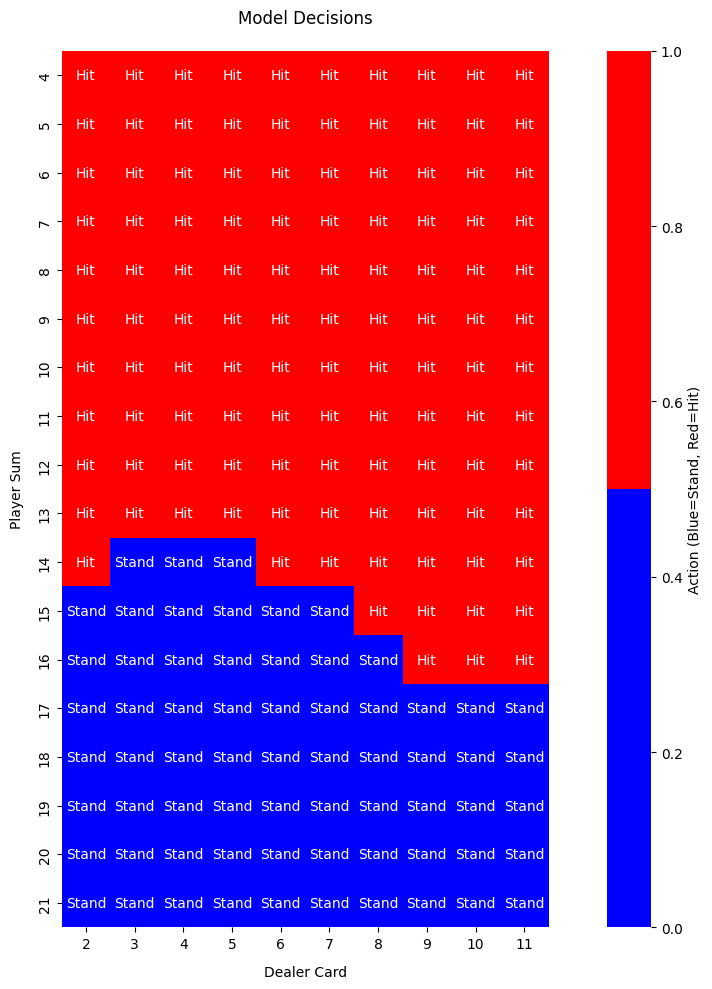

In [122]:
analyze_model_decisions(policy.network)

In [123]:
# Now we will do another heatmap, this time this one will presented maximum Q-value in each state
# It kinda tells us what model thinks about the state, is it a good one or bad one
def analyze_state_values(model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Creates a heatmap of expected values (maximum Q-value) for each state
    """
    model.eval()

    player_sums = range(4, 22)  # 4-21
    dealer_cards = range(2, 12)  # 2-11

    values = np.zeros((len(player_sums), len(dealer_cards)))

    with torch.no_grad():
        for i, player_sum in enumerate(player_sums):
            for j, dealer_card in enumerate(dealer_cards):
                state = torch.FloatTensor([player_sum, dealer_card, 0]).to(device)
                q_values = model(state).squeeze()
                # Maximum Q-value represents the expected value of the best action
                values[i, j] = q_values.max().item()

    plt.figure(figsize=(12, 10))
    sns.heatmap(values,
                cmap='RdYlGn',  # Red (bad) to Yellow (neutral) to Green (good)
                xticklabels=list(dealer_cards),
                yticklabels=list(player_sums),
                annot=True,
                fmt='.2f',
                square=True)
    plt.title('Expected Value Landscape', pad=20)
    plt.xlabel('Dealer Card', labelpad=10)
    plt.ylabel('Player Sum', labelpad=10)

    # Add explanatory text
    plt.figtext(0.02, -0.02,
                "Green = Higher expected value (better state)\nRed = Lower expected value (worse state)",
                fontsize=10)

    plt.tight_layout()

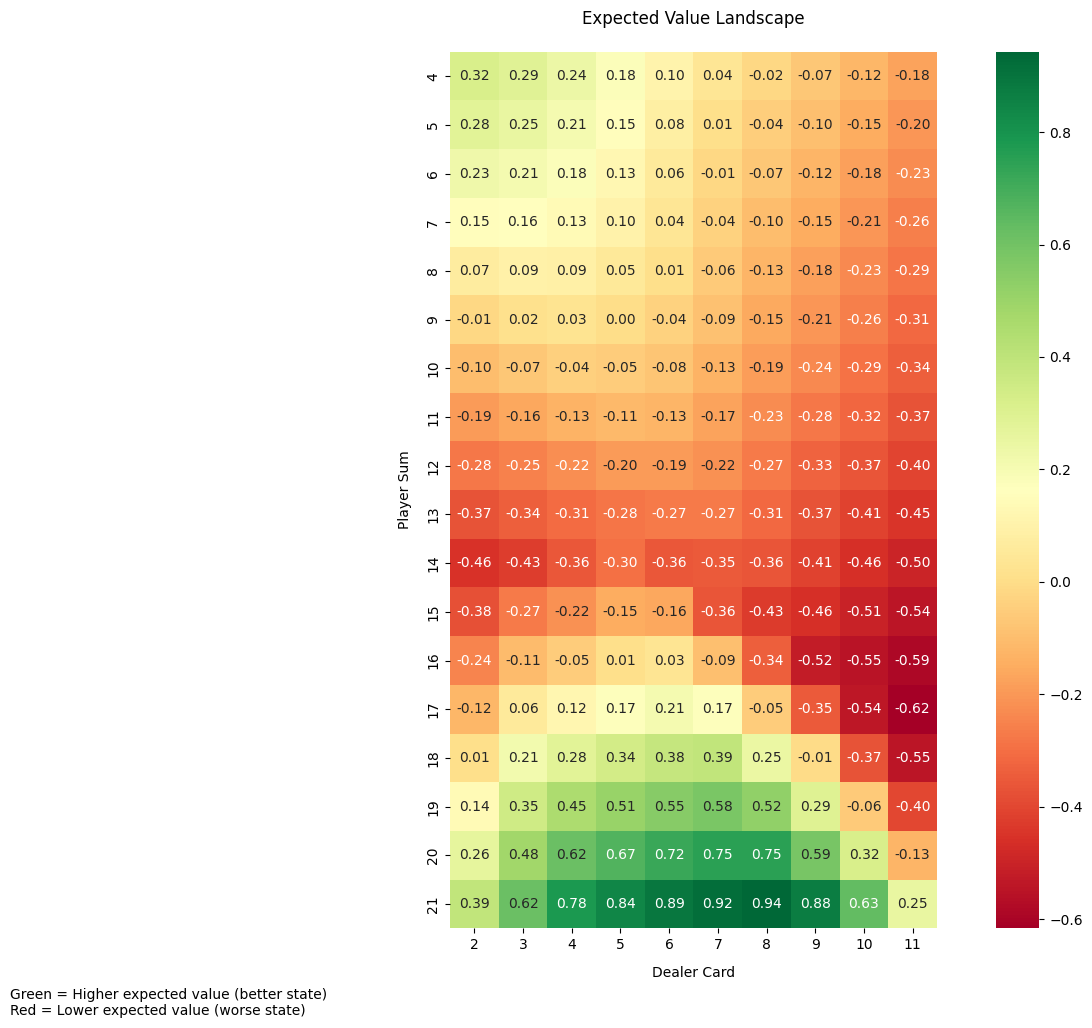

In [124]:
analyze_state_values(policy.network)